## This script is a modified version of [https://github.com/mlc-ai/notebooks/blob/main/4_Build_End_to_End_Model.ipynb]

In [69]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations

In [71]:
import torchvision
import torch

#get the test data with pytorch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

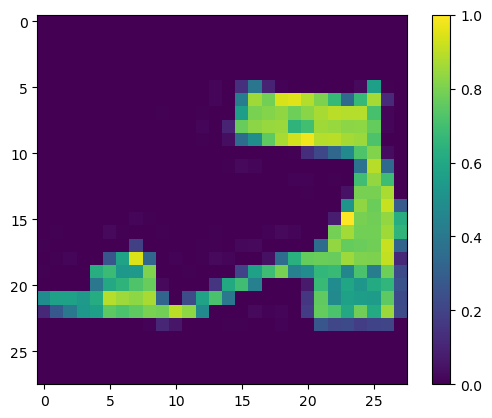

Class: Sandal


In [73]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [75]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

Weights and biases: [https://github.com/mlc-ai/web-data/blob/main/models/fasionmnist_mlp_params.pkl]

In [77]:
import pickle as pkl
mlp_params = pkl.load(open("./parameters/fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("Numpy-MLP Prediction:", class_names[pred_kind[0]])

[[-15.938702 -22.90845  -18.182028 -22.514837 -19.086128  20.452694
  -16.290257 -19.265121 -12.368678  -8.49461 ]]
[5]
Numpy-MLP Prediction: Sandal


In [111]:
#these are low level numpy implementations of each linear layer
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Sandal


In [117]:
def lnumpy_call_tir(prim_func, inputs, shape, dtype):
    res = np.empty(shape, dtype=dtype)
    prim_func(*inputs, res)
    return res

#this is an example of a computational graph abstraction
def lnumpy_mlp_with_call_tir(data, w0, b0, w1, b1):
    lv0 = lnumpy_call_tir(lnumpy_linear0, (data, w0, b0), (1, 128), dtype="float32")
    lv1 = lnumpy_call_tir(lnumpy_relu0, (lv0, ), (1, 128), dtype="float32")
    out = lnumpy_call_tir(lnumpy_linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    return out

result = lnumpy_mlp_with_call_tir(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = np.argmax(result, axis=1)
print("Low-level Numpy with callTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with callTIR Prediction: Sandal


In [119]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer((1, 128), "float32"),
              Y: T.Buffer((1, 128), "float32")):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"),
                W: T.Buffer((128, 784), "float32"),
                B: T.Buffer((128,), "float32"),
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer((1, 128), "float32"),
                W: T.Buffer((10, 128), "float32"),
                B: T.Buffer((10,), "float32"),
                Z: T.Buffer((1, 10), "float32")):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]


    @R.function #This tag is part of the relax from tvm, which provides high level neural network executions. 
                #This tag means that this function creates PackedFunc from primitive functions
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):

        #within the dataflow block, all executions are to be represented as nodes in a computational graph
        with R.dataflow():
            cls = MyModule

            #each call_tir can correspond to a node on a computational graph representing the whole neural network,
            #which passes parameters to the first layer, then to a relu, then to the final layer

            #we expect all computational graph nodes to be "side-effect free", which means that they do not allocate memory
            #all memory allocation in these graph representations should be performed seperate from the primitive tensor functions,
            #which means that we pass "handles" (pointers) of pre-allocated memory for function inputs AND outputs

            #side-effect free functions allows said functions to be modular and to be paralellized; we minimize memory dependencies

            #relax.call_tir takes the name of the function from the module (MyModule.linear0), the list of inputs to the 
            #layer (the input tensor, the first layer weights and biases, the shape of the output (1, 128), and the data type of the 
            #ouput tensor
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(cls.relu0, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(cls.linear1, (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))

            #relax output is the only output from the dataflow block
            R.output(out)
        return out

In [121]:
#modules using relax must be built with relax.build, whereas ones which only use tvm can be built with tvm.build,
#syntax is the same for both 
ex = relax.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm_build.Executable

In [123]:
#tells us that all intermediate computations are to be performed by cpu, the program is run on the virtual machine
vm = relax.VirtualMachine(ex, tvm.cpu())

In [127]:
#casts everything to tvm compatible types
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [129]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
nd_res

<tvm.nd.NDArray shape=(1, 10), cpu(0)>
array([[-15.938702, -22.908457, -18.182026, -22.514837, -19.086128,
         20.452694, -16.290257, -19.265118, -12.368677,  -8.494609]],
      dtype=float32)

In [131]:
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Sandal


In [133]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        # block 0
        with R.dataflow():

            #instead of calling tensor functions we created, this is using a library
            #upon runtime, the compiler expects to find a function labeled as whatever the given name is
            lv0 = R.call_dps_packed("env.linear", (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [147]:
#the way the compiler resolves the labels given by the user when calling relax.call_dps_packed is by registering each
#function, in which 
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):

    #torch.from_dlpack is a way of exchanging information without creating copies, both the tvm array and the torch array
    #point to the same piece of memory
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [152]:
ex = relax.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

In [160]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: Sandal


In [162]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"),
                W: T.Buffer((128, 784), "float32"),
                B: T.Buffer((128,), "float32"),
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]
                
    #this function uses a mixture of library calls and tvm script implementations
    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            cls = MyModuleMixture
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [164]:
ex = relax.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Sandal


In [166]:
#binding parameters to calls of the function
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
MyModuleWithParams.show()

In [168]:
ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Sandal
